### ______________________________________________________________________________

<div style="width:100%;text-align: right;">
    <img src="ensae.png" /> </div>
<div style="width:100%;text-align: center;">
   <br>
    <strong style="font-size:20px;">Projet de Machine Learning</strong>
    <br>
    <br>
    ***************
    <br>
</div>

<div style="width:100%;text-align: center;">
    <img src="seattle_image.png" style="width:35%;height:100%;" /> <br>
    <span style="font-size:20px;">SEA Building Energy Benchmarking : Prediction of Building Energy <br><strong>Partie Modélisation</strong></span>
</div>

### ______________________________________________________________________________

Cette partie du projet est dédiée à la modélisation en tant que telle. Pour voir le Pré-traitement <a href="Preprocessing.ipynb" target="_blank">Cliquer ici</a>

## Sommaire du document

In [4]:
##Sommaire à remplir

In [71]:
!pip install statsmodels

In [ ]:
## Importation des packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import set_config
from sklearn.svm import SVR
from sklearn.preprocessing import *
from sklearn.metrics import *
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, ElasticNet, SGDRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.pipeline import make_pipeline, Pipeline
from scipy.stats import *
import statsmodels.stats.diagnostic as smsd
import matplotlib.pyplot as plt

#### Importation de la base traitée

In [142]:
CleanedData=pd.read_csv("Clean_Data.csv")

In [143]:
CleanedData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7209 entries, 0 to 7208
Data columns (total 50 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   OSEBuildingID                             7209 non-null   float64
 1   DataYear                                  7209 non-null   float64
 2   NumberofFloors                            7209 non-null   float64
 3   PropertyGFABuilding(s)                    7209 non-null   float64
 4   PropertyGFAParking                        7209 non-null   float64
 5   ENERGYSTARScore                           7209 non-null   float64
 6   SiteEUI(kBtu/sf)                          7209 non-null   float64
 7   SiteEnergyUseWN(kBtu)                     7209 non-null   float64
 8   SourceEUI(kBtu/sf)                        7209 non-null   float64
 9   LargestPropertyUseTypeGFA                 7209 non-null   float64
 10  Electricity(kBtu)                   

Nous rappelons que nos variables targets sont les suivantes:

     1 - TotalGHGEmissions 
     2 - SiteEnergyUse(kBtu)

In [132]:
#### Suppression de quelques variables
var=['OSEBuildingID','ENERGYSTARScore','DataYear']
CleanedData.drop(var,inplace=True, axis=1)

### Normalité de nos variables cibles

Nos variables cibles, sont-elles normales?

In [133]:
for i in Y.columns:
    statistic, p_value = normaltest(Y[i])
    if p_value<0.05:
        print("La distribution de la variable "+i+" n'est pas normale")
    else:
        print("La distribution de la variable "+i+" est normale")

La distribution de la variable TotalGHGEmissions n'est pas normale
La distribution de la variable SiteEnergyUse(kBtu) n'est pas normale


### Que donnerait passage à l'échelle logarithmique sur les distributions des variables targets ?

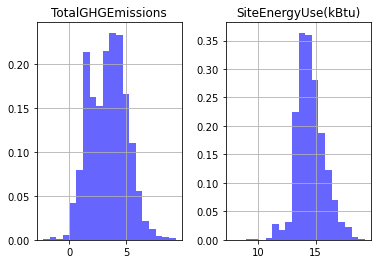

In [144]:
logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
Y_log = logtransformer.transform(Y)
Y_log.hist(bins=20, density=True, alpha=0.6, color='b')  
plt.show()

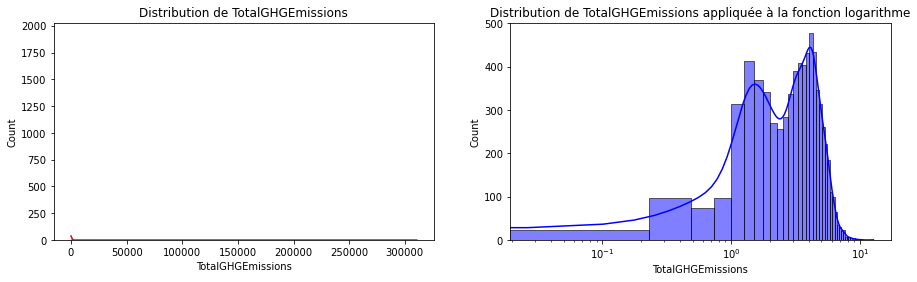

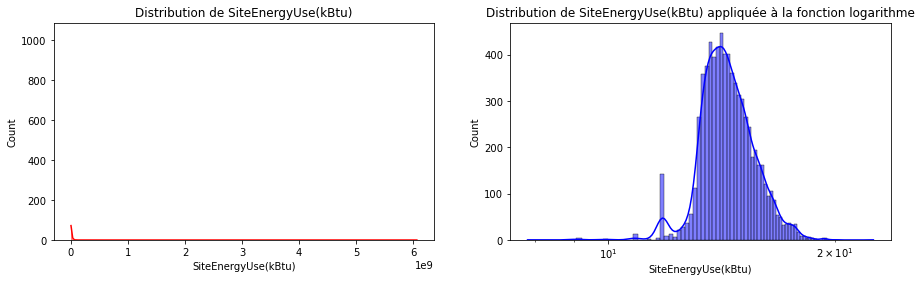

In [127]:
for i in Y.columns:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

    sns.histplot(Y[i], color='r', kde=True, ax=axes[0])
    axes[0].set_title('Distribution de '+i)

    log_y = np.log(Y[i])
    sns.histplot(log_y, color='b', kde=True, ax=axes[1])
    axes[1].set_title('Distribution de '+i+' appliquée à la fonction logarithme')
    axes[1].set_xscale('log');

L'application de la fonction s'approche de la normale mais elle ne le sont toujours pas.

In [145]:
target= CleanedData[['TotalGHGEmissions','SiteEnergyUse(kBtu)']]

In [146]:
min_values = np.min(target, axis = 0)
max_values = np.max(target, axis = 0)

target_normalized = (target - min_values)/(max_values - min_values)

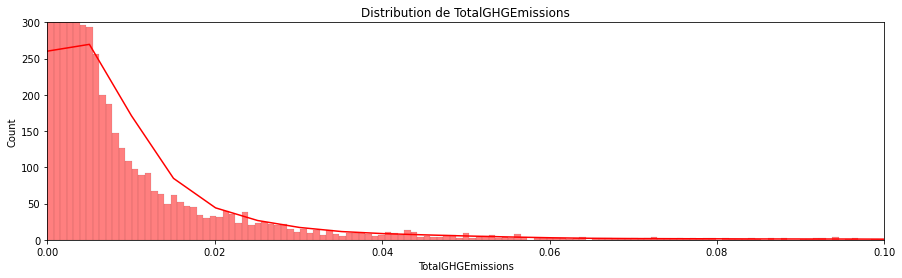

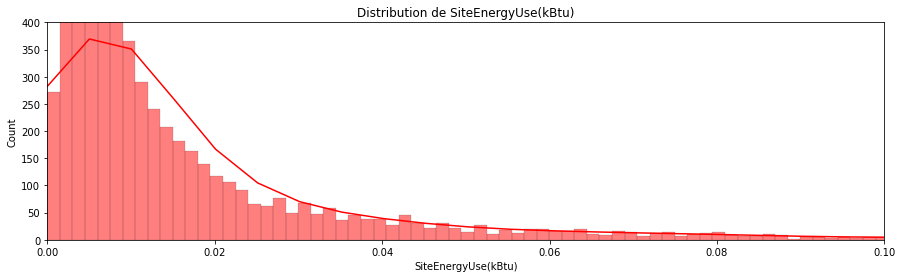

In [147]:
for i in target_normalized.columns:
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))
    sns.histplot(target_normalized[i], color='r', kde=True, ax=axes)
    axes.set_title('Distribution de '+i)
    if i=='TotalGHGEmissions':
        b=300
    else:
        b=400
    plt.xlim(0,0.1)
    plt.ylim(0,b)

La normalisation avec la méthode du **min-max** donne également une distribution qui n'est pas normale. Nous allons à présent continuer avec la distribution obtenue en appliquant le log.

## Préparation des jeux d'entrainement et de test
Afin de tester notre meilleur modèle sur des données "inconnues", nous allons subdiviser (split) notre jeu de données en deux parties pour obtenir un jeu d'entrainement et un jeu de test (20% des données)

In [148]:
Y = CleanedData[['TotalGHGEmissions','SiteEnergyUse(kBtu)']]
log_y=np.log(Y)
X = CleanedData.drop(['TotalGHGEmissions','SiteEnergyUse(kBtu)'], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, log_y, test_size=0.2, random_state=42)

print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))

Entrainement: 5767 lignes,
Test: 1442 lignes.



In [149]:
log_y.columns

Index(['TotalGHGEmissions', 'SiteEnergyUse(kBtu)'], dtype='object')

In [150]:
X.columns

Index(['OSEBuildingID', 'DataYear', 'NumberofFloors', 'PropertyGFABuilding(s)',
       'PropertyGFAParking', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEnergyUseWN(kBtu)', 'SourceEUI(kBtu/sf)',
       'LargestPropertyUseTypeGFA', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
       'GHGEmissionsIntensity', 'OHE_Campus', 'OHE_Multifamily',
       'OHE_NonResidential', 'OHE_SPS-District K-12',
       'OHE_Autres_Neighborhood', 'OHE_BALLARD', 'OHE_CENTRAL',
       'OHE_DELRIDGE NEIGHBORHOODS', 'OHE_DOWNTOWN', 'OHE_EAST',
       'OHE_GREATER DUWAMISH', 'OHE_LAKE UNION', 'OHE_MAGNOLIA / QUEEN ANNE',
       'OHE_NORTH', 'OHE_NORTHEAST', 'OHE_NORTHWEST', 'OHE_SOUTHEAST',
       'OHE_SOUTHWEST', 'OHE_Autres_LargestPropertyUseType',
       'OHE_Distribution Center', 'OHE_Hotel', 'OHE_K-12 School',
       'OHE_Multifamily Housing', 'OHE_Non-Refrigerated Warehouse',
       'OHE_Office', 'OHE_Other', 'OHE_Retail Store', 'OHE_Worship Facility',
       'OHE_Autres_ComplianceStatus', 'OHE_Complian

In [151]:
Y.TotalGHGEmissions.agg([min,max])

min        0.1
max    11031.5
Name: TotalGHGEmissions, dtype: float64

In [152]:
preprocessor = make_column_transformer((StandardScaler(),X.columns))

In [153]:
preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 Index(['OSEBuildingID', 'DataYear', 'NumberofFloors', 'PropertyGFABuilding(s)',
       'PropertyGFAParking', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEnergyUseWN(kBtu)', 'SourceEUI(kBtu/sf)',
       'LargestPropertyUseTypeGFA', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
       'GHGEmissionsIntensity', 'OHE_Campus',...
       'OHE_Distribution Center', 'OHE_Hotel', 'OHE_K-12 School',
       'OHE_Multifamily Housing', 'OHE_Non-Refrigerated Warehouse',
       'OHE_Office', 'OHE_Other', 'OHE_Retail Store', 'OHE_Worship Facility',
       'OHE_Autres_ComplianceStatus', 'OHE_Compliant', 'OHE_Not Compliant',
       'OHE_Account Requires Verification', 'OHE_Autres_ComplianceIssue',
       'OHE_No Issue', 'OHE_Portfolio Manager Account Not Shared'],
      dtype='object'))])

### Régression linéaire

In [159]:
model = make_pipeline(preprocessor,LinearRegression())
model.fit(X_train,Y_train)
print("Score d'entrainement = ",model.score(X_train,Y_train))
y_pred = model.predict(X_test)
print("Score de la prédiction :", model.score(X_test, Y_test)), 
print("Ecart absolu moyen = ",mean_absolute_error(Y_test,y_pred))
print("Racine carrée de l'erreur quadratique moyenne = ",np.sqrt(mean_squared_error(Y_test,y_pred)))
print("Erreur absolue médiane = ",median_absolute_error(Y_test,y_pred))

Score d'entrainement =  0.6749206403292407
Score de la prédiction : 0.6821793424375386
Ecart absolu moyen =  0.5703310783915237
Racine carrée de l'erreur quadratique moyenne =  0.789820443405828
Erreur absolue médiane =  0.4039713153593244


Le Score d'entrainement de **0.67** montre que **notre modèle de régression linéaire** est capable de bien d'apprendre les caractéristiques des données. Il est proche du score de la prédiction qui est de **0.68** qui est également significatif. Cela nous renseigne de la performance significative de notre modèle à se généraliser à de nouvelles données et de savoir  ...

##### Essayons d'évaluons le modèle par target pour voir si elle peut être plus performante

In [160]:
for i in log_y.columns:
    X_train, X_test, Y_train, Y_test = train_test_split(X, log_y[i], test_size=0.2, random_state=42)
    model = make_pipeline(preprocessor,LinearRegression())
    model.fit(X_train,Y_train)
    print(i)
    print("Score d'entrainement = ",model.score(X_train,Y_train))
    y_pred = model.predict(X_test)
    print("Score de la prédiction :", model.score(X_test, Y_test)), 
    print("Ecart absolu moyen = ",mean_absolute_error(Y_test,y_pred))
    print("Racine carrée de l'erreur quadratique moyenne = ",np.sqrt(mean_squared_error(Y_test,y_pred)))
    print("Erreur absolue médiane = ",median_absolute_error(Y_test,y_pred))
    print("_"*75)

TotalGHGEmissions
Score d'entrainement =  0.7035316467913183
Score de la prédiction : 0.7086085523242189
Ecart absolu moyen =  0.6301365645814679
Racine carrée de l'erreur quadratique moyenne =  0.8661402139514923
Erreur absolue médiane =  0.44838186723589346
___________________________________________________________________________
SiteEnergyUse(kBtu)
Score d'entrainement =  0.6463083894476762
Score de la prédiction : 0.655745905052912
Ecart absolu moyen =  0.5105504576999762
Racine carrée de l'erreur quadratique moyenne =  0.705296422900386
Erreur absolue médiane =  0.3601261753048366
___________________________________________________________________________


En estimant le modèle de régression linéaire pour chaque target, on constate une amélioration nette des scores (d'entrainement, de la prédiction) pour la target **TotalGHGEmissions**. Par ailleurs, même si les scores ont légèrement baissé pour la target **SiteEnergyUse(kBtu)**, les MSE, RMSE, MAE ont également baissé. Cela permet de voir que  la performance du modèle s'améliore sur la target **TotalGHGEmissions**.

A présent testons différents modèles sur notre jeux de données afin de déterminer lequel est le meilleur. 

In [171]:
# Définition des différents modèles
DiffModels = {
    'RandomForestRegressor' : RandomForestRegressor(),
    'XGBRegressor' : XGBRegressor(),
    'SGDRegressor': SGDRegressor(),
    'SVR': SVR(),
    'LinearRegression' : LinearRegression(),
    'Ridge' : Ridge(),
    'Lasso' : Lasso(tol=0.2),
    'ElasticNet' : ElasticNet(),
}

In [174]:
##Resultats = []
for nom_model, DModels in DiffModels.items():
    print('Algorithme: ',nom_model)
    for i in log_y.columns:
        X_train, X_test, Y_train, Y_test = train_test_split(X, log_y[i], test_size=0.2, random_state=45)
        model = make_pipeline(preprocessor,DModels)
        model.fit(X_train,Y_train)
        y_pred = model.predict(X_test)
        print('Prédiction de la target ',i)
        print('Score d\'entrainement = ',model.score(X_train,Y_train))
        print("Score de la prédiction: ",  model.score(X_test, Y_test))
        mae = mean_absolute_error(Y_test,y_pred)
        rmse = np.sqrt(mean_squared_error(Y_test,y_pred))
        med_abs_err = median_absolute_error(Y_test,y_pred)
        print("MAE = ", mae)        
        print("RMSE = ",rmse)
        print("Median abs err = ", med_abs_err)
        print('')
        ##Resultats.append([nom_model, i, model.score(X_test, Y_test), mae, rmse, med_abs_err])
        print('*'*50)
    print('='*75)

Algorithme:  RandomForestRegressor
Prédiction de la target  TotalGHGEmissions
Score d'entrainement =  0.9937290488323055
Score de la prédiction:  0.953448627371677
MAE =  0.1584171750565311
RMSE =  0.3393820491048474
Median abs err =  0.02277651776477585

**************************************************
Prédiction de la target  SiteEnergyUse(kBtu)
Score d'entrainement =  0.9917642018320453
Score de la prédiction:  0.9416992096575869
MAE =  0.1286901514606411
RMSE =  0.2852649851263658
Median abs err =  0.014168432765796268

**************************************************
Algorithme:  XGBRegressor
Prédiction de la target  TotalGHGEmissions
Score d'entrainement =  0.9910771750611255
Score de la prédiction:  0.9556064036110825
MAE =  0.18763100286668574
RMSE =  0.3314231086213641
Median abs err =  0.07582974356862271

**************************************************
Prédiction de la target  SiteEnergyUse(kBtu)
Score d'entrainement =  0.9874142446218915
Score de la prédiction:  0.94

Par constat, les meilleurs modéles sont rangées dans l'ordre suivant :

    1 - **RandomForestRegressor** : il a les scores de training et de test les plus élevés de tous les modèles testés. Ces scores sont respectivement (0.9937, 0.9919)->target1 et (0.9542, 0.9395)->target2
    2 - **XGBRegressor**

Dans la suite, nous essayerons d'optimiser les hyperparamètres du **RandomForestRegressor** qui est notre meilleur modèle. Mais puisque ce modèle est déja très performant (il a un R2 score très élevé et des erreurs très faibles), nous ferons en même temps le tuning des hyperparamètres du modèle **Ridge** afin de pouvoir véritablement observer les effet du tuning des hyperparamètres.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, log_y, test_size=0.2, random_state=45)
param_grid = {'n_estimators': [10, 50, 100, 200],
             'max_depth' : [None, 5, 10, 15],
             'min_samples_split': [2, 5, 10, 15],
             'min_samples_leaf' : [1, 2, 4, 6]}
rand_forest = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rand_forest, param_grid = param_grid, cv = 5, 
                           n_jobs = -1, verbose = 2)
grid_search.fit(X_train, Y_train)
print('Les meilleures paramètres pour les targets')
print(grid_search.best_params_)
print("*"*80)

In [ ]:
y_pred = grid_search.best_estimator_.predict(X_test)
from sklearn.metrics import mean_squared_error as MSE
rmse_test = np.sqrt(MSE(Y_test, y_pred))
print("Test score: ", np.round(rmse_test, 2))
print(y_pred)

In [184]:
# Définissez les valeurs que vous voulez tester pour l'hyperparamètre alpha
X_train, X_test, Y_train, Y_test = train_test_split(X, log_y, test_size=0.2, random_state=45)
param_grid = {'alpha': [0.1, 0.5, 1, 5, 10]}

# Créez un modèle de Ridge
model = Ridge()

# Créez un objet GridSearchCV en spécifiant un scoring et en utilisant la validation croisée à 5 plis
grid_search2 = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)

# Ajustez l'objet GridSearchCV au jeu de données d'entraînement
grid_search2.fit(X_train, Y_train)

# Affichez les hyperparamètres optimaux
print(grid_search2.best_params_)


C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.64699e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.68627e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.77428e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.70814e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarnin

{'alpha': 5}


In [187]:
y_pred = grid_search2.best_estimator_.predict(X_test)
from sklearn.metrics import mean_squared_error as MSE
rmse_test = np.sqrt(MSE(Y_test, y_pred))
print("Test score: ", np.round(rmse_test, 2))
print(y_pred)

Test score:  0.77
[[ 3.32426098 14.91107144]
 [ 3.91721433 14.66510317]
 [ 5.15436529 14.87761474]
 ...
 [ 5.60073259 15.76344712]
 [ 2.9350079  13.62417948]
 [ 4.80931798 15.30643226]]


Définissons à présent un cross validation sur nos deux modèles